# INFO 698 Capstone
Fall 2025

***Academic University Student GPA Data Modeling and Analysis***

Code written by **Phillip McManus**

### Library imports for all models and functions in code

In [350]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score
from pygam import LinearGAM, f
from sklearn.tree import DecisionTreeRegressor, plot_tree
import seaborn as sns
import matplotlib.pyplot as plt

### Data import and cleansing

In [351]:
filepath = 'C:/Users/phill/INFO698-Capstone/Anonymized Dataset for Info Science MS.csv'
data = pd.read_csv(filepath)

In [352]:
# Drop all records that do not include a Term GPA, as this will be our response variable for all models
data = data.dropna(subset = ['TermGPA'])

In [4]:
# Saving code that found outliers in the data set, but ones that we ultimately decided to keep in the data
# data.loc[(data['UnitsPassedincludedinGPA'] == 0) & (data['UnitsPassednotincludedinGPA'] == 0) & (data['TermGPA'] > 0)]
# data.loc[(data['UnitsPassedincludedinGPA'] == 0) & (data['UnitsPassednotincludedinGPA'] > 0)]
# data.loc[(data['UnitsPassedincludedinGPA'] == 0) & (data['UnitsPassednotincludedinGPA'] == 0) & (data['TermGPA'] == 0)]

In [353]:
# Group ages into ranges for categorical scoring
data['AgeGroups'] = pd.cut(data['Age'], bins=[0,24,39,59,100], labels=['<25','25-39','40-59','60+'])
data['AgeGroups'].value_counts()

AgeGroups
25-39    30543
<25      15603
40-59     9024
60+        399
Name: count, dtype: int64

In [6]:
# Create a weighted GPA value to give more weight to those taking more classes 
# --Did not end up using this--

# data['WeightedGPA'] = data['TermGPA'] * data['UnitsPassedincludedinGPA']
# data[['TermGPA', 'UnitsPassedincludedinGPA', 'WeightedGPA']]

In [7]:
# Create zscore values for each categorical field to feed into the model in addition to one-hot encoding of membership in each group
# --Did not end up using this--

# data['zFirstGen'] = data.groupby('FirstGenerationFlag', observed=True)['TermGPA'].transform(zscore)
# data['zAge'] = data.groupby('AgeGroups', observed=True)['TermGPA'].transform(zscore)
# data['zGender'] = data.groupby('Gender', observed=True)['TermGPA'].transform(zscore)
# data['zMilitary'] = data.groupby('PrimaryMilitaryAffiliation', observed=True)['TermGPA'].transform(zscore)
# data['zCollege'] = data.groupby('College', observed=True)['TermGPA'].transform(zscore)
# data['zCollege'] = data['zCollege'].fillna(0) # Corrects issue of only 2 observations from one of the colleges producing NaN
# data['zAcademicCareer'] = data.groupby('AcademicCareer', observed=True)['TermGPA'].transform(zscore)
# data['zAcademicLevel'] = data.groupby('AcademicLevelEndofTerm', observed=True)['TermGPA'].transform(zscore)
# data['zFullTimePartTime'] = data.groupby('UAFullTimePartTime', observed=True)['TermGPA'].transform(zscore)
# data['zClassesEnrolled'] = data.groupby('NumberofClassesEnrolled', observed=True)['TermGPA'].transform(zscore)

In [354]:
# Set the y response variable to the TermGPA
y = data['TermGPA']

### Functions for different models

In [355]:
# Function for Basic Linear Regression model w/ one-hot encoding of categorical features

def linear_basic (X, y):
    model = LinearRegression()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return r2, rmse

In [356]:
# Function for Linear Regression w/ K-Fold Cross Validation
# Perform K-Fold Cross Validation using 10 folds to get the most accurate predictive power of the model
# Use a column transformer inside a pipeline to ensure the one-hot encoding for categorical features is only applied to the training set

def linear_cv (X, y):
    model = LinearRegression()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    cross_validation = KFold(n_splits=10, shuffle=True, random_state=314)
    cv_scores = cross_validate(full_pipeline, X, y, cv=cross_validation, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [357]:
# Function for Linear Regression w/ K-Fold Cross Validation on folds that have been stratified
#    to ensure even distribution of the firstgen feature

def linear_strat (X, y):
    model = LinearRegression()
    scoring_metrics = ['r2', 'neg_mean_squared_error']
    
    preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    stratify_feature = X['FirstGenerationFlag']
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    cv_splits = cross_validation.split(X, stratify_feature)
    
    cv_scores = cross_validate(full_pipeline, X, y, cv=cv_splits, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [358]:
# Function for Linear Regression w/ Stratified K-Fold Cross Validation + L1 Lasso Regularization

def linear_l1 (X, y, a):
    model = Lasso(alpha=a, max_iter=5000, tol=0.01, random_state=314)
    scaler = StandardScaler()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', scaler), ('regressor', model)])

    stratify_feature = X['FirstGenerationFlag']
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    cv_splits = cross_validation.split(X, stratify_feature)
    
    cv_scores = cross_validate(full_pipeline, X, y, cv=cv_splits, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [359]:
# Function for Linear Regression w/ Stratified K-Fold Cross Validation + L2 Ridge Regularization

def linear_l2 (X, y, a):
    model = Ridge(alpha=a, max_iter=5000, tol=0.01, random_state=314)
    scaler = StandardScaler()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', scaler), ('regressor', model)])

    stratify_feature = X['FirstGenerationFlag']
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    cv_splits = cross_validation.split(X, stratify_feature)
    
    cv_scores = cross_validate(full_pipeline, X, y, cv=cv_splits, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [360]:
# Function for Linear Regression w/ Stratified K-Fold Cross Validation + L1 Lasso Regularization, adding in interaction terms

def linear_l1_Interactions (X, y, a):
    model = Lasso(alpha=a, max_iter=5000, tol=0.01, random_state=314)
    scaler = StandardScaler()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    X_int = create_interactions(X)
    
    full_pipeline = Pipeline(steps=[('scaler', scaler), ('regressor', model)])

    stratify_feature = X['FirstGenerationFlag']
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    cv_splits = cross_validation.split(X_int, stratify_feature)
    
    cv_scores = cross_validate(full_pipeline, X_int, y, cv=cv_splits, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [361]:
# Function for Linear Regression w/ Stratified K-Fold Cross Validation + L2 Ridge Regularization, adding in interaction terms

def linear_l2_Interactions (X, y, a):
    model = Ridge(alpha=a, max_iter=5000, tol=0.01, random_state=314)
    scaler = StandardScaler()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    X_int = create_interactions(X)
    
    full_pipeline = Pipeline(steps=[('scaler', scaler), ('regressor', model)])

    stratify_feature = X['FirstGenerationFlag']
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    cv_splits = cross_validation.split(X_int, stratify_feature)
    
    cv_scores = cross_validate(full_pipeline, X_int, y, cv=cv_splits, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [362]:
# Function for a GAM (Generalized Additive Model) w/ Stratified K-Fold Cross Validation

def linear_gam (X, y):
    X_codes = pd.DataFrame()
    gam_terms = []
    
    for i, feature in enumerate(X.columns):
        X_codes[feature], _ = pd.factorize(X[feature])
        if i == 0:
            gam_terms = f(i)
        else:
            gam_terms += f(i)
        
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    stratify_feature = X['FirstGenerationFlag']
    stratify_codes, _ = pd.factorize(stratify_feature)
    
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    
    r2_scores = []
    rmse_scores = []
    for train_index, test_index in cross_validation.split(X_codes, stratify_codes):
        X_train, X_test = X_codes.iloc[train_index], X_codes.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = LinearGAM(gam_terms).fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        r2_scores.append(r2_score(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    r2 = np.mean(r2_scores)
    rmse = np.mean(rmse_scores)

    return r2, rmse

### Function to call models and save results

In [363]:
# Function takes a list of different models and feature sets and returns all their results in a dictionary

def feature_set_models(feature_sets, results):
    # Optimal alpha value found for L1 Lasso Regularization
    a_l1 = 0.0001

    # Optimal alpha value found for L2 Ridge Regularization
    a_l2 = 500.0
    
    for model_type, name, features in feature_sets:
        X = data[features]

        if model_type == 'Linear: Basic':
            r2, rmse = linear_basic(X, y)
        elif model_type == 'Linear: K-Fold CV':
            r2, rmse = linear_cv(X, y)
        elif model_type == 'Linear: K-Fold Strat':
            r2, rmse = linear_strat(X, y)
        elif model_type == 'Linear: L1 Lasso':
            r2, rmse = linear_l1(X, y, a_l1)
        elif model_type == 'Linear: L1 Interactions':
            r2, rmse = linear_l1_Interactions(X, y, a_l1)
        elif model_type == 'Linear: L2 Ridge':
            r2, rmse = linear_l2(X, y, a_l2)
        elif model_type == 'Linear: L2 Interactions':
            r2, rmse = linear_l2_Interactions(X, y, a_l2)
        elif model_type == 'Linear: GAM':
            r2, rmse = linear_gam(X, y)

        results.append({
            'Model': model_type + " - " + name,
            'R2': r2,
            'RMSE': rmse
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='R2', ascending=False)
    return(results_df)

### Function to create feature interactions

In [364]:
# Create interaction terms between FirstGenerationFlag and all other features in dataset, after one-hot encoding

def create_interactions(X):
    primary_feature = 'FirstGenerationFlag'
    other_features = [col for col in X.columns if col != primary_feature]

    # Run one-hot encoding on all the other features
    ohe_others = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
    others_encoded = ohe_others.fit_transform(X[other_features])
    others_names = ohe_others.get_feature_names_out(other_features)
    df_others = pd.DataFrame(others_encoded, columns=others_names, index=X.index)

    # Encode the primary feature
    ohe_primary = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')
    primary_encoded = ohe_primary.fit_transform(X[[primary_feature]])
    primary_names = ohe_primary.get_feature_names_out([primary_feature])
    df_primary = pd.DataFrame(primary_encoded, columns=primary_names, index=X.index)

    # Create the desired interactions between the primary feature and all others
    df_interactions = pd.DataFrame(index=X.index)
    for p_col in df_primary.columns:
        for o_col in df_others.columns:
            interaction_name = f"{p_col}_X_{o_col}"
            df_interactions[interaction_name] = df_primary[p_col] * df_others[o_col]

    # Combine all features together, keeping the original features with the interaction terms
    X_out = pd.concat([df_primary, df_others, df_interactions], axis=1)
    
    return X_out

### Functions for visualizations

In [365]:
# Function for scatterplot of R2 and RMSE values

def scatter(data):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=data,
        x='R2',
        y='RMSE',
        hue='Model',
        s=150,
        palette='deep')
    
    plt.xlabel(r'$R^2$ Score (Higher is Better)')
    plt.ylabel('RMSE (Lower is Better)')
    plt.title('Model Performance Comparison (R-squared vs. RMSE)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.)
    
    plt.show()

In [366]:
# Function for bar chart of R2 values

def bar(data):
    plt.figure(figsize=(6, 4))
    sns.barplot(data=data, x='R2', y='Model')
    plt.show()

### Model Exploration

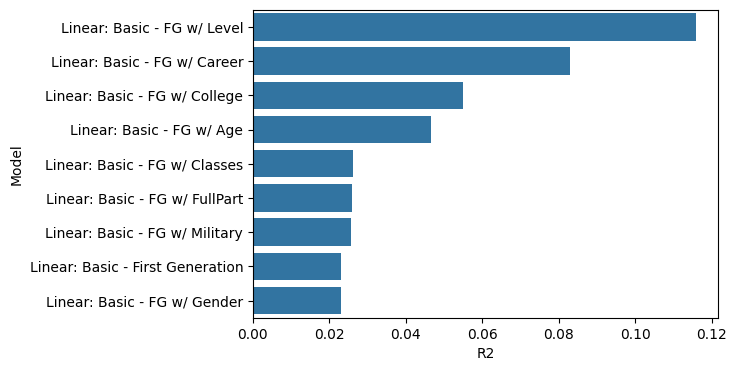

In [367]:
# Run basic regression on the First Generation Flag with each other feature individually

model_results = []
feature_sets = [
    ('Linear: Basic', 'First Generation', ['FirstGenerationFlag']),
    ('Linear: Basic', 'FG w/ College', ['FirstGenerationFlag', 'College']),
    ('Linear: Basic', 'FG w/ Age', ['FirstGenerationFlag', 'AgeGroups']),
    ('Linear: Basic', 'FG w/ Military', ['FirstGenerationFlag', 'PrimaryMilitaryAffiliation']),
    ('Linear: Basic', 'FG w/ Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'FG w/ Career', ['FirstGenerationFlag', 'AcademicCareer']),
    ('Linear: Basic', 'FG w/ Gender', ['FirstGenerationFlag', 'Gender']),
    ('Linear: Basic', 'FG w/ FullPart', ['FirstGenerationFlag', 'UAFullTimePartTime']),
    ('Linear: Basic', 'FG w/ Classes', ['FirstGenerationFlag', 'NumberofClassesEnrolled'])    
]
results_linear_individual = feature_set_models(feature_sets, model_results)
bar(results_linear_individual)

# Results show that the following features do not add any increase in GPA prediction to the First Generation Flag:
#    Gender, PrimaryMilitaryAffiliation, UAFullTimePartTime, NumberofClassesEnrolled
# The following features all increase the R^2 when combined with FirstGen:
#    AcademicLevelEndofTerm, AcademicCareer, College, AgeGroups

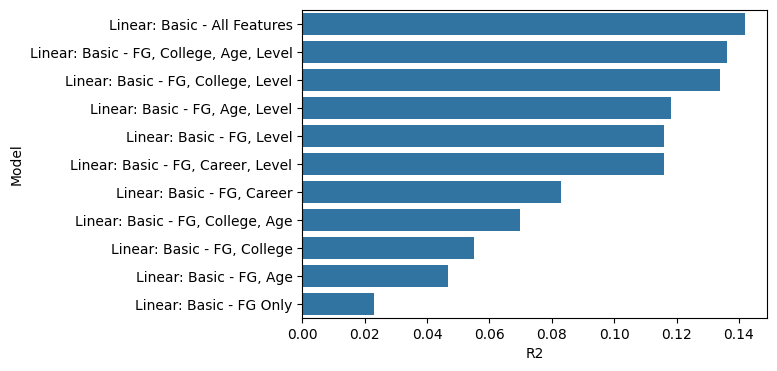

In [280]:
# Run different combinations of the found relevant features

model_results = []
feature_sets = [
    ('Linear: Basic', 'FG Only', ['FirstGenerationFlag']),
    ('Linear: Basic', 'FG, College', ['FirstGenerationFlag', 'College']),
    ('Linear: Basic', 'FG, Age', ['FirstGenerationFlag', 'AgeGroups']),
    ('Linear: Basic', 'FG, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'FG, Career', ['FirstGenerationFlag', 'AcademicCareer']),
    ('Linear: Basic', 'FG, Career, Level', ['FirstGenerationFlag', 'AcademicCareer', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'FG, Age, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'AgeGroups']),
    ('Linear: Basic', 'FG, College, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'College']),
    ('Linear: Basic', 'FG, College, Age', ['FirstGenerationFlag', 'College', 'AgeGroups']),
    ('Linear: Basic', 'FG, College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_combos = feature_set_models(feature_sets, model_results)
bar(results_linear_combos)

# Results show the following:
#    Addition of AcademicCareer adds nothing to the performance of AcademicLevelEndofTerm, so this appears to be redundant information
#    AcademicLevelEndofTerm and College both add large performance gains
#    AgeGroups adds a small amount, but still worth having it in place
#    The inclusion of all the other non-relevant features do add a small amount of performance over the core 3

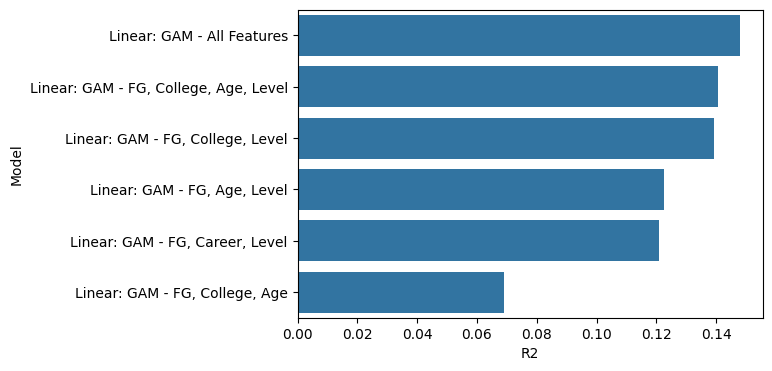

In [291]:
# Run different combinations through the GAM to look for best performing options

model_results = []
feature_sets = [
    ('Linear: GAM', 'FG, Career, Level', ['FirstGenerationFlag', 'AcademicCareer', 'AcademicLevelEndofTerm']),
    ('Linear: GAM', 'FG, Age, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'AgeGroups']),
    ('Linear: GAM', 'FG, College, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'College']),
    ('Linear: GAM', 'FG, College, Age', ['FirstGenerationFlag', 'College', 'AgeGroups']),
    ('Linear: GAM', 'FG, College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: GAM', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_combos = feature_set_models(feature_sets, model_results)
bar(results_linear_combos)

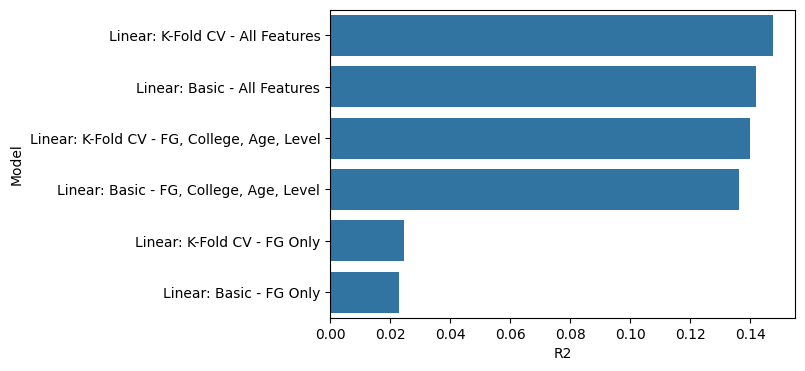

In [281]:
# Take the key groupings and run both basic linear regression and K-Fold Cross Validation to compare model performance

model_results = []
feature_sets = [
    ('Linear: Basic', 'FG Only', ['FirstGenerationFlag']),
    ('Linear: Basic', 'FG, College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: K-Fold CV', 'FG Only', ['FirstGenerationFlag']),
    ('Linear: K-Fold CV', 'FG, College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: K-Fold CV', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_cvcompare = feature_set_models(feature_sets, model_results)
bar(results_linear_cvcompare)

# Results show the following:
#    Addition of AcademicCareer adds nothing to the performance of AcademicLevelEndofTerm, so this appears to be redundant information
#    AcademicLevelEndofTerm and College both add large performance gains
#    AgeGroups adds a small amount, but still worth having it in place
#    The inclusion of all the other non-relevant features do add a small amount of performance over the core 3

In [165]:
# Calculate the percent improvement in R2 from adding K-Fold Cross Validation

rmse_cv_firstgen = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG Only')]['RMSE'].item()
r2_cv_firstgen = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG Only')]['R2'].item()
rmse_basic_firstgen = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - FG Only')]['RMSE'].item()
r2_basic_firstgen = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - FG Only')]['R2'].item()
rmse_cv_gain_firstgen = (rmse_cv_firstgen - rmse_basic_firstgen) / rmse_basic_firstgen
r2_cv_gain_firstgen = (r2_cv_firstgen - r2_basic_firstgen) / r2_basic_firstgen

rmse_cv_core = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG, College, Age, Level')]['RMSE'].item()
r2_cv_core = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG, College, Age, Level')]['R2'].item()
rmse_basic_core = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - FG, College, Age, Level')]['RMSE'].item()
r2_basic_core = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - FG, College, Age, Level')]['R2'].item()
rmse_cv_gain_core = (rmse_cv_core - rmse_basic_core) / rmse_basic_core
r2_cv_gain_core = (r2_cv_core - r2_basic_core) / r2_basic_core

rmse_cv_all = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - All Features')]['RMSE'].item()
r2_cv_all = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - All Features')]['R2'].item()
rmse_basic_all = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - All Features')]['RMSE'].item()
r2_basic_all = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - All Features')]['R2'].item()
rmse_cv_gain_all = (rmse_cv_all - rmse_basic_all) / rmse_basic_all
r2_cv_gain_all = (r2_cv_all - r2_basic_all) / r2_basic_all


print("Improvement in R2 from adding K-Fold Cross Validation to Basic Linear Regression")
print(f"First Generation Only: \t\tRMSE: {rmse_cv_gain_firstgen:+.2f}%\tR2: {r2_cv_gain_firstgen:+.2f}%")
print(f"College, Age & Academic Level: \tRMSE: {rmse_cv_gain_core:+.2f}%\tR2: {r2_cv_gain_core:+.2f}%")
print(f"All Features: \t\t\tRMSE: {rmse_cv_gain_all:+.2f}%\tR2: {r2_cv_gain_all:+.2f}%")

Improvement in R2 from adding K-Fold Cross Validation to Basic Linear Regression
First Generation Only: 		RMSE: +0.02%	R2: +0.06%
College, Age & Academic Level: 	RMSE: +0.01%	R2: +0.03%
All Features: 			RMSE: +0.01%	R2: +0.04%


In [166]:
# Calculate the percent improvement in metrics from adding features

rmse_gain_core = (rmse_cv_core - rmse_cv_firstgen) / rmse_cv_firstgen
r2_gain_core = (r2_cv_core - r2_cv_firstgen) / r2_cv_firstgen
rmse_gain_all = (rmse_cv_all - rmse_cv_core) / rmse_cv_core
r2_gain_all = (r2_cv_all - r2_cv_core) / r2_cv_core

print("Improvement in metrics from adding features within K-Fold Cross Validation")
print(f"First Generation Only: \t\tRMSE: {rmse_cv_firstgen:.2f}\t\t\tR2: {r2_cv_firstgen:.2f}")
print(f"College, Age & Academic Level: \tRMSE: {rmse_cv_core:.2f}\t{rmse_gain_core:+.2f}%\t\tR2: {r2_cv_core:.2f}\t{r2_gain_core:+.2f}%")
print(f"All Features: \t\t\tRMSE: {rmse_cv_all:.2f}\t{rmse_gain_all:+.2f}%\t\tR2: {r2_cv_all:.2f}\t{r2_gain_all:+.2f}%")

Improvement in metrics from adding features within K-Fold Cross Validation
First Generation Only: 		RMSE: 1.16			R2: 0.02
College, Age & Academic Level: 	RMSE: 1.09	-0.06%		R2: 0.14	+4.69%
All Features: 			RMSE: 1.08	-0.00%		R2: 0.15	+0.06%


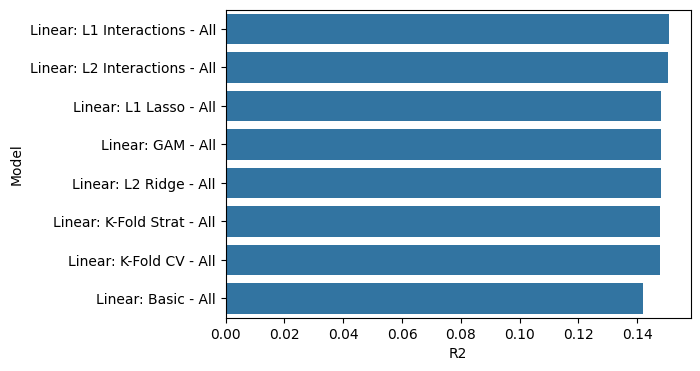

In [368]:
# Run all features through all versions of linear regression to compare model performance

model_results = []
feature_sets = [
    ('Linear: Basic', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: K-Fold CV', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: K-Fold Strat', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: L1 Lasso', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: L1 Interactions', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: L2 Ridge', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: L2 Interactions', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: GAM', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_compare = feature_set_models(feature_sets, model_results)
bar(results_linear_compare)

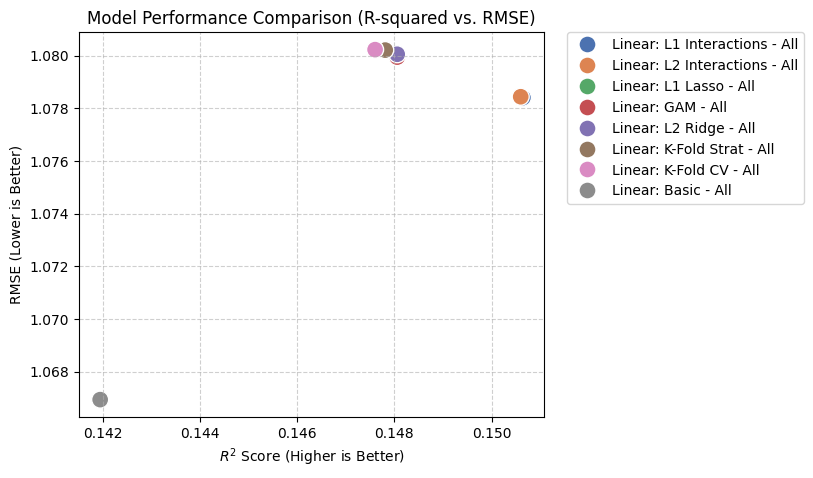

In [369]:
scatter(results_linear_compare)

### Parameter Searching for L1 and L2

In [181]:
# Run a parameter grid search using GridSearchCV to find the best alpha for L1 Lasso Regularization
X = data[['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']]

# model = Lasso(random_state=314)
model = Ridge(random_state=314)

scaler = StandardScaler()
preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', scaler), ('regressor', model)])

param_grid = {'regressor__alpha': [100.0, 400.0, 500.0, 600.0, 700.0]}

grid_search = GridSearchCV(estimator=full_pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
grid_search.fit(X, y)

print(f"Best Alpha found: {grid_search.best_params_}")
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validated RMSE: {best_rmse:.2f}")

best_pipeline = grid_search.best_estimator_
lasso_model = best_pipeline.named_steps['regressor']
coefficients = lasso_model.coef_
preprocessor = best_pipeline.named_steps['preprocessor']
feature_names_out = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_out,
    'Coefficient': coefficients
})
feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(
    by='Abs_Coefficient', 
    ascending=False
).reset_index(drop=True)

print("Lasso Feature Importance")
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.replace("onehotencoder__", "")
feature_importance_df['Abs_Coefficient'] = feature_importance_df['Abs_Coefficient'].round(2)
feature_importance_df['Value'] = feature_importance_df['Feature'].str.split('_').str.get(1)
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.split('_').str.get(0)
print(feature_importance_df[['Feature', 'Value', 'Abs_Coefficient']])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Alpha found: {'regressor__alpha': 500.0}
Best Cross-Validated RMSE: 1.08
Lasso Feature Importance
                       Feature                           Value  \
0       AcademicLevelEndofTerm                        Freshman   
1                      College         Undergraduate Education   
2       AcademicLevelEndofTerm                        Graduate   
3               AcademicCareer                        Graduate   
4               AcademicCareer                   Undergraduate   
5       AcademicLevelEndofTerm                          Senior   
6       AcademicLevelEndofTerm                       Sophomore   
7                      College     Eller College of Management   
8   PrimaryMilitaryAffiliation                     Active Duty   
9                      College  Colleges of Letters Arts & Sci   
10                     College  College of Information Science   
11  PrimaryMilitaryAffiliation              

In [98]:
# Add interaction terms into L1 Lasso Regularization to find best options for feature importance with First Gen Flag

X = data[['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']]

model = Lasso(random_state=314)

preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                ('interactions', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), 
                                ('regressor', model)])

param_grid = {'regressor__alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(estimator=full_pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
grid_search.fit(X, y)

print(f"Best Alpha found: {grid_search.best_params_}")
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validated RMSE: {best_rmse:.2f}")

best_pipeline = grid_search.best_estimator_
lasso_model = best_pipeline.named_steps['regressor']
coefficients = lasso_model.coef_
preprocessor = best_pipeline.named_steps['preprocessor']
feature_names_out = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_out,
    'Coefficient': coefficients
})
feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(
    by='Abs_Coefficient', 
    ascending=False
).reset_index(drop=True)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


C:\Users\phill\anaconda3\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.957e+02, tolerance: 7.611e+00
  model = cd_fast.enet_coordinate_descent(


Best Alpha found: {'regressor__alpha': 0.0001}
Best Cross-Validated RMSE: 1.07


ValueError: All arrays must be of the same length

In [126]:
# Get feature importance data from L1 w/ interaction run

initial_encoded_names = best_pipeline.named_steps['interactions'].get_feature_names_out(input_features=feature_names_out)
feature_importance_df = pd.DataFrame({
    'Feature': initial_encoded_names,
    'Coefficient': coefficients})

print("Lasso Feature Importance")
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.replace("onehotencoder__", "")
feature_importance_df['Coefficient'] = np.abs(feature_importance_df['Coefficient'].round(2))
feature_importance_df['Value'] = feature_importance_df['Feature'].str.split('_').str.get(1)
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.split('_').str.get(0)
print(feature_importance_df[['Feature', 'Value', 'Coefficient']])

Lasso Feature Importance
                      Feature                           Value  Coefficient
0         FirstGenerationFlag                               N          0.0
1         FirstGenerationFlag                               Y          0.0
2                     College  Col Arch Plan & Landscape Arch          0.0
3                     College       Coll of Ag Life & Env Sci          0.0
4                     College   College of Applied Sci & Tech          0.0
...                       ...                             ...          ...
1765  NumberofClassesEnrolled       8 NumberofClassesEnrolled          0.0
1766  NumberofClassesEnrolled       8 NumberofClassesEnrolled          0.0
1767  NumberofClassesEnrolled       9 NumberofClassesEnrolled          0.0
1768  NumberofClassesEnrolled       9 NumberofClassesEnrolled          0.0
1769  NumberofClassesEnrolled      10 NumberofClassesEnrolled          0.0

[1770 rows x 3 columns]


### Other Data Visualizations

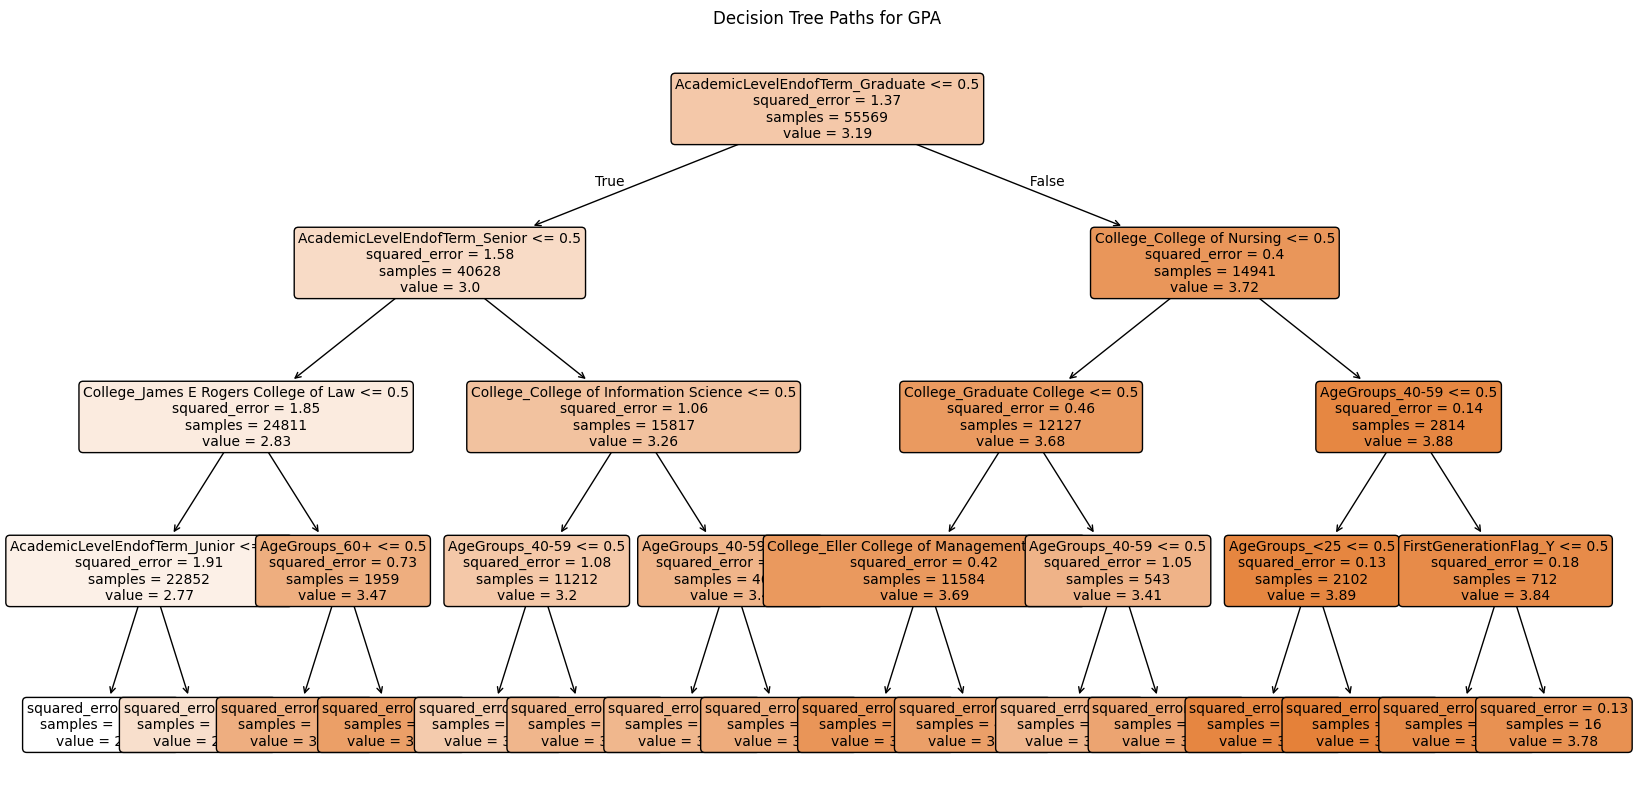

In [343]:
# Decision tree

from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

X = data[['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']]

X_ohe = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
feature_names = [name.replace("onehotencoder__", "") for name in feature_names]
X_ohe_df = pd.DataFrame(X_ohe, columns=feature_names)

model = DecisionTreeRegressor(max_depth=4, random_state=314)
model.fit(X_ohe_df, y)

plt.figure(figsize=(20, 10))
plot_tree(
    model,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=10,
    precision=2
)
plt.title("Decision Tree Paths for GPA")
plt.show()